In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import StandardScaler

In [11]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")


GPU is available and being used


In [3]:
df = pd.read_csv(r'C:\Users\smbm2\projects\FlowClassification\datasets\covertype\covtype.csv')

In [4]:
le = LabelEncoder()
df['Cover_Type'] = le.fit_transform(df['Cover_Type'])

df['Cover_Type'].value_counts()

1    283301
0    211840
2     35754
6     20510
5     17367
4      9493
3      2747
Name: Cover_Type, dtype: int64

In [5]:
class SingleTaskDataset(Dataset):
    def __init__(self, df : pd.DataFrame, task1_column):
        self.n = df.shape[0]
        
        self.task1_labels = df[task1_column].astype(np.int64).values

        self.scalar = StandardScaler()
        self.x = self.scalar.fit_transform(df.drop(columns=[task1_column])).astype(np.float32)
        # self.x = df.drop(task1_column, axis=1).astype(np.float32).values

    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        features = self.x[idx]
        labels_task1 = self.task1_labels[idx]

        return features, labels_task1
        # return self.x[index], self.task1_labels[index], self.task2_labels[index]
    
exp_dataset = SingleTaskDataset(df, "Cover_Type")


# Split training and testing samples
train_size = int(0.8*len(exp_dataset)) # Use a different ratio if you want
test_size = len(exp_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(exp_dataset, [train_size, test_size])

print(f"Train length: {len(train_dataset)}, Test length: {len(test_dataset)}") # See the ratios

batch_size = 256 #Hyperparameter that you should try messing with depending on the size of your dataset. The smaller it is, the more stochastic and chaotic the training gets.

# Wrapping with dataloader so that its easy to extract batches from the train and test subsets
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True) 

Train length: 464809, Test length: 116203


In [6]:
# each task loss is scaled by its own learnable parameter, then regularization is applied 
class UncertaintyLoss(nn.Module):
    def __init__(self, num_tasks):
        super(UncertaintyLoss, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.CrossEntropyLoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1
        prediction = predictions[0]
        loss_fn = self.loss_fns[0]
        task_loss = loss_fn(prediction, target)
        
        return task_loss

In [9]:
# All the layers of the model

class MultiHeadAttention(nn.Module):
    def __init__(self, embed_size, heads):
        super(MultiHeadAttention, self).__init__()

        self.embed_size = embed_size
        self.heads = heads
        self.head_dim = embed_size // heads
        assert(self.head_dim * heads == embed_size), "Embed size needs to be div by heads"
        self.values = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.keys =nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.queries = nn.Linear(self.head_dim, self.head_dim, bias=False)
        self.fc_out = nn.Linear(heads*self.head_dim, embed_size)


    def forward(self, values, keys, query):
        N = query.shape[0]
        value_len, key_len, query_len = values.shape[1], keys.shape[1], query.shape[1]

        values = values.reshape(N, value_len, self.heads, self.head_dim)
        keys = keys.reshape(N, key_len, self.heads, self.head_dim)
        queries = query.reshape(N, query_len, self.heads, self.head_dim)

        values = self.values(values)
        keys = self.keys(keys)
        queries = self.queries(queries)

        energy = torch.einsum("nqhd,nkhd->nhqk", [queries, keys])

        attention = torch.softmax(energy / (self.embed_size ** (1/2)), dim=3) #(batch_size, head_dim, #query_embeddings, #key_embeddings)

        # Calculate simplified attention scores
        avg_attention = attention.mean(dim=0)  # Average across batches
        # print("batch average", avg_attention.shape)
        avg_attention = avg_attention.mean(dim=0).squeeze(dim=0)
        # print("head average", avg_attention.shape)

        out = torch.einsum("nhql,nlhd->nqhd", [attention, values]).reshape(N, query_len, self.heads*self.head_dim) #(batch_size, n_features, embed_size)
        out = self.fc_out(out)

        return out, avg_attention
    
class TransformerBlock(nn.Module):
    def __init__(self, embed_size, heads, dropout, forward_expansion, pre_norm_on):
        super(TransformerBlock, self).__init__()

        self.pre_norm_on = pre_norm_on
        if self.pre_norm_on:
            self.pre_norm = nn.LayerNorm(embed_size)
        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm1 = nn.LayerNorm(embed_size)
        self.norm2 = nn.LayerNorm(embed_size)

        self.feed_forward = nn.Sequential(nn.Linear(embed_size, forward_expansion*embed_size),
                                          nn.ReLU(),
                                          nn.Linear(forward_expansion*embed_size, embed_size)
                                          )
        self.dropout = nn.Dropout(dropout)

    def forward(self,value,key,query):
        if self.pre_norm_on:
            query = self.pre_norm(query)
            key = self.pre_norm(key)
            value = self.pre_norm(value)
            
        attention, avg_attention = self.attention(value, key, query)
        x = self.dropout(self.norm1(attention + query))
        forward = self.feed_forward(x)
        out = self.dropout(self.norm2(forward + x))
        return out, avg_attention
    
class DecoderBlock(nn.Module):
    def __init__(self, embed_size, heads, forward_expansion, dropout, pre_norm_on):
        super(DecoderBlock, self).__init__()

        self.attention = MultiHeadAttention(embed_size, heads)
        self.norm = nn.LayerNorm(embed_size)
        self.transformer_block = TransformerBlock(embed_size, heads, dropout, forward_expansion, pre_norm_on)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, value, key):
        out, avg_attention = self.transformer_block(value, key, x)

        return out, avg_attention

class Decoder(nn.Module):
    def __init__(self,
                 embed_size,
                 num_layers,
                 heads,
                 forward_expansion,
                 decoder_dropout,
                 pre_norm_on
    ):
        super(Decoder, self).__init__()

        self.layers = nn.ModuleList(
                [
                    DecoderBlock(
                        embed_size,
                        heads,
                        dropout=decoder_dropout,
                        forward_expansion=forward_expansion,
                        pre_norm_on=pre_norm_on
                    )
                    for _ in range(num_layers)
                ]
            )
        self.avg_attention = None

    def forward(self, class_embed, context):
        for layer in self.layers:
            # x is the classification embedding (CLS Token)
            # context are the feature embeddings that will be used as key and value
            x, self.avg_attention = layer(class_embed, context, context)
  
        return x 

class Embeddings(nn.Module):
    def __init__(self, sigma, embed_size, input_size, embedding_dropout, n_features, num_target_labels, rff_on):
        super(Embeddings, self).__init__()

        self.rff_on = rff_on

        if self.rff_on:
            self.rffs = nn.ModuleList([GaussianEncoding(sigma=sigma, input_size=input_size, encoded_size=embed_size//2) for _ in range(n_features)])
            self.dropout = nn.Dropout(embedding_dropout)
            self.mlp_in = embed_size
        else:
            self.mlp_in = input_size

        self.embeddings = nn.ModuleList([nn.Linear(in_features=self.mlp_in, out_features=embed_size) for _ in range(n_features)])

        # Classifcation Embeddings for each target label
        self.target_label_embeddings = nn.ModuleList([nn.Embedding(1, embed_size) for _ in range(num_target_labels)])


    def forward(self, x):
        x = x.unsqueeze(2) #(batch_size, n_features) -> (batch_size, n_features, 1)
        rff_vectors = []
        if self.rff_on:
            for i, r in enumerate(self.rffs):
                input = x[:,i,:]
                out = r(input)
                rff_vectors.append(out)
        
            x = torch.stack(rff_vectors, dim=1)
        
        embeddings = []
        for i, e in enumerate(self.embeddings):
            goin_in = x[:,i,:]
            goin_out = e(goin_in)
            embeddings.append(goin_out)

        target_label_embeddings_ = []
        for e in self.target_label_embeddings:
            input = torch.tensor([0], device=x.device)
            temp = e(input)
            temp = temp.repeat(x.size(0), 1)
            tmep = temp.unsqueeze(1)
            target_label_embeddings_.append(temp)

        class_embeddings = torch.stack(target_label_embeddings_, dim=1)
        
        # class_embed = self.classification_embedding(torch.tensor([0], device=x.device))  # use index 0 for the classification embedding
        # class_embed = class_embed.repeat(x.size(0), 1) # -> (batch_size, embed_size)
        # class_embed = class_embed.unsqueeze(1)

        context = torch.stack(embeddings, dim=1)

        return class_embeddings, context

class classificationHead(nn.Module):
    def __init__(self, embed_size, dropout, mlp_scale_classification, num_target_classes):
        super(classificationHead, self).__init__()
        
        #flattening the embeddings out so each sample in batch is represented with a 460 dimensional vector
        self.input = embed_size
        self.lin1 = nn.Linear(self.input, mlp_scale_classification*self.input)
        self.drop = nn.Dropout(dropout)
        self.lin2 = nn.Linear(mlp_scale_classification*self.input, mlp_scale_classification*self.input)
        self.lin3 = nn.Linear(mlp_scale_classification*self.input, self.input)
        self.lin4 = nn.Linear(self.input, num_target_classes)
        self.relu = nn.ReLU()
        self.initialize_weights()

    def initialize_weights(self): #he_initialization.
        torch.nn.init.kaiming_normal_(self.lin1.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin1.bias)

        torch.nn.init.kaiming_normal_(self.lin3.weight, nonlinearity='relu')
        torch.nn.init.zeros_(self.lin3.bias)

    def forward(self, x):

        x= torch.reshape(x, (-1, self.input))

        x = self.lin1(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin2(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin3(x)
        x = self.relu(x)
        x = self.drop(x)
        x = self.lin4(x)
  
        return x


# DEFAULT PARAMETERS SET UP FOR VPN DATASET. BE CAREFUL AND MAKE SURE YOU SET THEM UP HOW YOU WANT.
class Classifier(nn.Module):
    def __init__(self, 
                 rff_on = False,
                 sigma=4,
                 embed_size=20,
                 input_size=1,
                 embedding_dropout = 0,
                 n_features=23, # YOU WILL PROBABLY NEED TO CHANGE
                 num_layers=1,
                 heads=1,
                 forward_expansion=4, # Determines how wide the MLP is in the encoder. Its a scaling factor. 
                 decoder_dropout=0,
                 classification_dropout = 0,
                 pre_norm_on = False,
                 mlp_scale_classification = 4,
                 targets_classes : list=  [3,8]
                 ):
        super(Classifier, self).__init__()

        self.embeddings = Embeddings(rff_on=rff_on, sigma=sigma, embed_size=embed_size, input_size=input_size, embedding_dropout=embedding_dropout, n_features=n_features, num_target_labels=len(targets_classes))
        self.decoder = Decoder(embed_size=embed_size, num_layers=num_layers, heads=heads, forward_expansion=forward_expansion, decoder_dropout=decoder_dropout, pre_norm_on=pre_norm_on)
        self.classifying_heads = nn.ModuleList([classificationHead(embed_size=embed_size, dropout=classification_dropout, mlp_scale_classification=mlp_scale_classification, num_target_classes=x) for x in targets_classes])
        
    def forward(self, x):
        class_embed, context = self.embeddings(x)

        x = self.decoder(class_embed, context)
        
        probability_dist_raw = []
        for i, e in enumerate(self.classifying_heads):
            input = x[:, i,:]
            output = e(input)
            probability_dist_raw.append(output)
        
        return probability_dist_raw


In [7]:
# Training and Testing Loops
# Should not need modification

def train(dataloader, model, loss_function, optimizer, device_in_use):
    model.train()

    total_loss = 0

    total_correct_1 = 0
    total_samples_1 = 0
    all_targets_1 = []
    all_predictions_1 = []

    total_correct_2 = 0
    total_samples_2 = 0
    all_targets_2 = []
    all_predictions_2 = []

    for (features,labels_task1,) in dataloader:
        features,labels_task1 = features.to(device_in_use),labels_task1.to(device_in_use)


        task_predictions = model(features) #contains a list of the tensor outputs for each task

        loss = loss_function(task_predictions, labels_task1)
        total_loss += loss.item()

        #computing accuracy for first target
        y_pred_softmax_1 = torch.softmax(task_predictions[0], dim=1)
        _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
        total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
        total_samples_1 += labels_task1.size(0)
        all_targets_1.extend(labels_task1.cpu().numpy())
        all_predictions_1.extend(y_pred_labels_1.cpu().numpy())

        # #computing accuaracy for second target
        # y_pred_softmax_2 = torch.softmax(task_predictions[1], dim=1)
        # _, y_pred_labels_2 = torch.max(y_pred_softmax_2, dim=1)
        # total_correct_2 += (y_pred_labels_2 == labels_task2).sum().item()
        # total_samples_2 += labels_task2.size(0)
        # all_targets_2.extend(labels_task2.cpu().numpy())
        # all_predictions_2.extend(y_pred_labels_2.cpu().numpy())

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss/len(dataloader)
    accuracy_1 = total_correct_1 / total_samples_1
    # accuracy_2 = total_correct_2 / total_samples_2

    # # precision = precision_score(all_targets, all_predictions, average='weighted')
    # recall = recall_score(all_targets, all_predictions, average='weighted')
    # f1 = f1_score(all_targets, all_predictions, average='weighted')

    return avg_loss, accuracy_1
    

def test(dataloader, model, loss_function, device_in_use):
  model.eval()
  total_loss = 0
  
  total_correct_1 = 0
  total_samples_1 = 0
  all_targets_1 = []
  all_predictions_1 = []

  total_correct_2 = 0
  total_samples_2 = 0
  all_targets_2 = []
  all_predictions_2 = []

  with torch.no_grad():
    for (features,labels_task1) in dataloader:
      features,labels_task1 = features.to(device_in_use),labels_task1.to(device_in_use)

      #compute prediction error
      task_predictions = model(features) #contains a list of the tensor outputs for each task

      loss = loss_function(task_predictions, labels_task1)
      total_loss += loss.item()

      #computing accuracy for first target
      y_pred_softmax_1 = torch.softmax(task_predictions[0], dim=1)
      _, y_pred_labels_1 = torch.max(y_pred_softmax_1, dim=1)
      total_correct_1 += (y_pred_labels_1 == labels_task1).sum().item()
      total_samples_1 += labels_task1.size(0)
      all_targets_1.extend(labels_task1.cpu().numpy())
      all_predictions_1.extend(y_pred_labels_1.cpu().numpy())

      # #computing accuaracy for second target
      # y_pred_softmax_2 = torch.softmax(task_predictions[1], dim=1)
      # _, y_pred_labels_2 = torch.max(y_pred_softmax_2, dim=1)
      # total_correct_2 += (y_pred_labels_2 == labels_task2).sum().item()
      # total_samples_2 += labels_task2.size(0)
      # all_targets_2.extend(labels_task2.cpu().numpy())
      # all_predictions_2.extend(y_pred_labels_2.cpu().numpy())

  avg = total_loss/len(dataloader)
  accuracy_1 = total_correct_1 / total_samples_1
  # accuracy_2 = total_correct_2 / total_samples_2
  # recall = recall_score(all_targets, all_predictions, average='weighted')
  f1_1 = f1_score(all_targets_1, all_predictions_1, average='weighted')
  # f1_2 = f1_score(all_targets_2, all_predictions_2, average="weighted")

  return avg, accuracy_1, all_predictions_1, all_targets_1, f1_1

def format_metric(value): # Used to format the metrics output
    return f"{value:.2f}"

In [12]:
model = Classifier(n_features=54, pre_norm_on=True, rff_on=True, targets_classes=[7]).to(device_in_use) # Instantiate the model
loss_functions = UncertaintyLoss(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.

epochs = 10 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
train_accuracies_2 = []
train_recalls = [] 
train_f1_scores = [] 
test_losses = []
test_accuracies_1 = []
test_accuracies_2 = []
test_recalls = []  
test_f1_scores = [] 
all_attention_scores = []

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  # test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, covertype Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, covertype Accuracy {format_metric(test_accuracy_1)}, covertype F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

  # Save the model after pre-training
  torch.save(model.state_dict(), 'model_trained.pth')

  # total_attention = model.decoder.avg_attention
  # all_attention_scores.append(total_attention.tolist()) #UPDATED
  # model.decoder.avg_attention = None


# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve for covertype')
plt.legend()


# plt.subplot(1, 3, 3)
# plt.plot(range(1, epochs+1), train_accuracies_2, label='Train Accuracy')
# plt.plot(range(1, epochs+1), test_accuracies_2, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Test Accuracy Curve for Traffic Type')
# plt.legend()
# plt.tight_layout()
# plt.tight_layout()
# plt.show()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for covertype")
print(conf_matrix_1)

# # Display confusion matrix for the second task (Application Type) on test data
# conf_matrix_2 = confusion_matrix(all_targets_2, all_predictions_2)
# print("Confusion Matrix for Application Type")
# print(conf_matrix_2)

# print(f"Best accuracy: {max(test_accuracies)}")

# # Plot attention scores for each feature over epochs

# # all_attention_scores = all_attention_scores.cpu().numpy() #CUDA tensor needs to be converted to cpu tensor
# all_attention_scores = torch.tensor(all_attention_scores)
# plt.figure(figsize=(10, 6))

# features = df.drop("class1", axis=1).columns.tolist()

# for feature_idx in range(all_attention_scores.shape[1]):
#     plt.plot(all_attention_scores[:, feature_idx], label=features[feature_idx])

# plt.xlabel('Epochs')
# plt.ylabel('Attention Scores')
# plt.title('Attention Scores for Each Feature over Epochs')
# plt.legend(loc = 'lower left')
# plt.show()

# last_epoch_attention_scores = all_attention_scores[-1]
# top_scores, top_indices = torch.topk(last_epoch_attention_scores, k=10)

# # Display the top 10 attention scores and the corresponding feature
# for i in range(10):
#     print(f"{i+1}. {features[int(top_indices[i])]}: {top_scores[i]}")

KeyboardInterrupt: 

Epoch [ 1/50]        | Train: Loss 0.71, covertype Accuracy 0.69                         | Test: Loss 0.62, covertype Accuracy 0.74, covertype F1 0.72
Epoch [ 2/50]        | Train: Loss 0.58, covertype Accuracy 0.75                         | Test: Loss 0.55, covertype Accuracy 0.77, covertype F1 0.76
Epoch [ 3/50]        | Train: Loss 0.53, covertype Accuracy 0.77                         | Test: Loss 0.51, covertype Accuracy 0.78, covertype F1 0.78
Epoch [ 4/50]        | Train: Loss 0.50, covertype Accuracy 0.79                         | Test: Loss 0.48, covertype Accuracy 0.80, covertype F1 0.79
Epoch [ 5/50]        | Train: Loss 0.46, covertype Accuracy 0.81                         | Test: Loss 0.45, covertype Accuracy 0.81, covertype F1 0.81
Epoch [ 6/50]        | Train: Loss 0.44, covertype Accuracy 0.82                         | Test: Loss 0.44, covertype Accuracy 0.82, covertype F1 0.82
Epoch [ 7/50]        | Train: Loss 0.42, covertype Accuracy 0.83                         | Tes

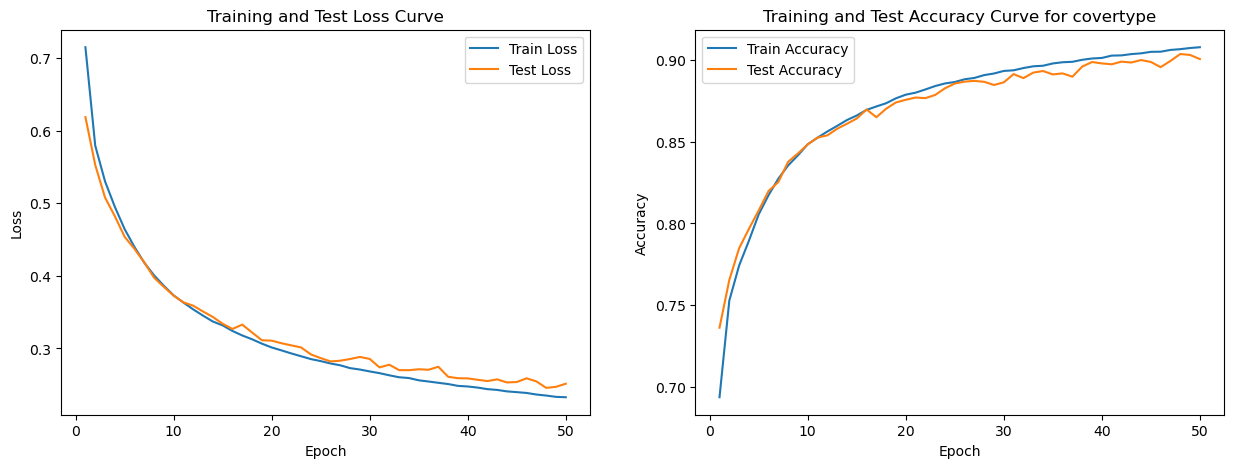

In [10]:
model = Classifier(n_features=54, pre_norm_on=True, rff_on=True, targets_classes=[7]).to(device_in_use) # Instantiate the model
loss_functions = UncertaintyLoss(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.

epochs = 50 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
train_accuracies_2 = []
train_recalls = [] 
train_f1_scores = [] 
test_losses = []
test_accuracies_1 = []
test_accuracies_2 = []
test_recalls = []  
test_f1_scores = [] 
all_attention_scores = []

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  # test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, covertype Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, covertype Accuracy {format_metric(test_accuracy_1)}, covertype F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

  # Save the model after pre-training
  torch.save(model.state_dict(), 'model_trained.pth')

  # total_attention = model.decoder.avg_attention
  # all_attention_scores.append(total_attention.tolist()) #UPDATED
  # model.decoder.avg_attention = None


# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve for covertype')
plt.legend()


# plt.subplot(1, 3, 3)
# plt.plot(range(1, epochs+1), train_accuracies_2, label='Train Accuracy')
# plt.plot(range(1, epochs+1), test_accuracies_2, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Test Accuracy Curve for Traffic Type')
# plt.legend()
# plt.tight_layout()
# plt.tight_layout()
# plt.show()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for covertype")
print(conf_matrix_1)

# # Display confusion matrix for the second task (Application Type) on test data
# conf_matrix_2 = confusion_matrix(all_targets_2, all_predictions_2)
# print("Confusion Matrix for Application Type")
# print(conf_matrix_2)

# print(f"Best accuracy: {max(test_accuracies)}")

# # Plot attention scores for each feature over epochs

# # all_attention_scores = all_attention_scores.cpu().numpy() #CUDA tensor needs to be converted to cpu tensor
# all_attention_scores = torch.tensor(all_attention_scores)
# plt.figure(figsize=(10, 6))

# features = df.drop("class1", axis=1).columns.tolist()

# for feature_idx in range(all_attention_scores.shape[1]):
#     plt.plot(all_attention_scores[:, feature_idx], label=features[feature_idx])

# plt.xlabel('Epochs')
# plt.ylabel('Attention Scores')
# plt.title('Attention Scores for Each Feature over Epochs')
# plt.legend(loc = 'lower left')
# plt.show()

# last_epoch_attention_scores = all_attention_scores[-1]
# top_scores, top_indices = torch.topk(last_epoch_attention_scores, k=10)

# # Display the top 10 attention scores and the corresponding feature
# for i in range(10):
#     print(f"{i+1}. {features[int(top_indices[i])]}: {top_scores[i]}")

Epoch [ 1/75]        | Train: Loss 0.68, covertype Accuracy 0.71                         | Test: Loss 0.60, covertype Accuracy 0.74, covertype F1 0.73
Epoch [ 2/75]        | Train: Loss 0.57, covertype Accuracy 0.75                         | Test: Loss 0.55, covertype Accuracy 0.76, covertype F1 0.75
Epoch [ 3/75]        | Train: Loss 0.52, covertype Accuracy 0.78                         | Test: Loss 0.50, covertype Accuracy 0.78, covertype F1 0.78
Epoch [ 4/75]        | Train: Loss 0.47, covertype Accuracy 0.80                         | Test: Loss 0.46, covertype Accuracy 0.81, covertype F1 0.80
Epoch [ 5/75]        | Train: Loss 0.44, covertype Accuracy 0.82                         | Test: Loss 0.42, covertype Accuracy 0.83, covertype F1 0.82
Epoch [ 6/75]        | Train: Loss 0.41, covertype Accuracy 0.83                         | Test: Loss 0.40, covertype Accuracy 0.84, covertype F1 0.83
Epoch [ 7/75]        | Train: Loss 0.39, covertype Accuracy 0.84                         | Tes

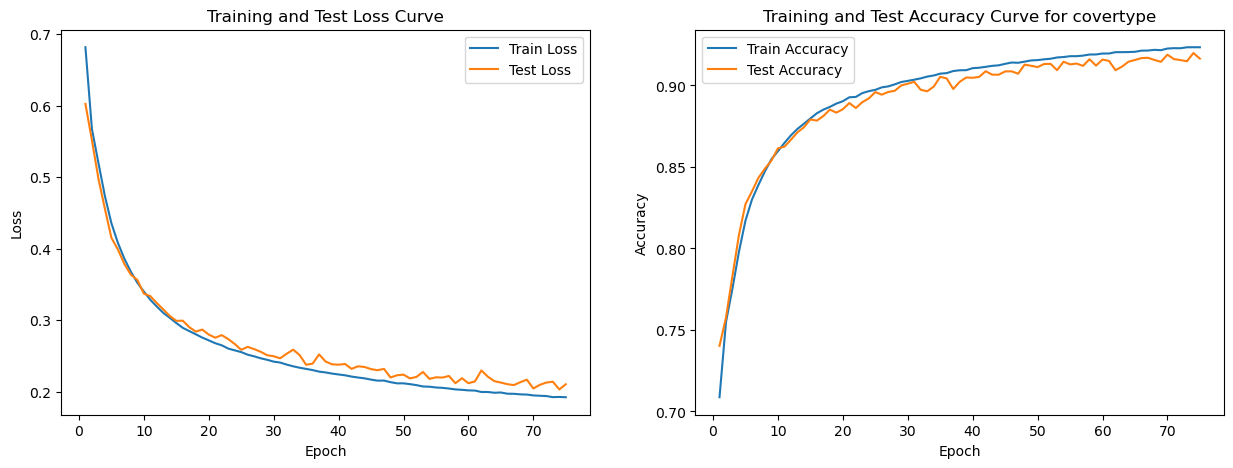

In [13]:
model = Classifier(n_features=54, pre_norm_on=True, rff_on=True, targets_classes=[7], sigma=2).to(device_in_use) # Instantiate the model
loss_functions = UncertaintyLoss(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.

epochs = 75 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
train_accuracies_2 = []
train_recalls = [] 
train_f1_scores = [] 
test_losses = []
test_accuracies_1 = []
test_accuracies_2 = []
test_recalls = []  
test_f1_scores = [] 
all_attention_scores = []

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  # test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, covertype Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, covertype Accuracy {format_metric(test_accuracy_1)}, covertype F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

  # Save the model after pre-training
  torch.save(model.state_dict(), 'model_trained.pth')

  # total_attention = model.decoder.avg_attention
  # all_attention_scores.append(total_attention.tolist()) #UPDATED
  # model.decoder.avg_attention = None


# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve for covertype')
plt.legend()


# plt.subplot(1, 3, 3)
# plt.plot(range(1, epochs+1), train_accuracies_2, label='Train Accuracy')
# plt.plot(range(1, epochs+1), test_accuracies_2, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Test Accuracy Curve for Traffic Type')
# plt.legend()
# plt.tight_layout()
# plt.tight_layout()
# plt.show()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for covertype")
print(conf_matrix_1)

# # Display confusion matrix for the second task (Application Type) on test data
# conf_matrix_2 = confusion_matrix(all_targets_2, all_predictions_2)
# print("Confusion Matrix for Application Type")
# print(conf_matrix_2)

# print(f"Best accuracy: {max(test_accuracies)}")

# # Plot attention scores for each feature over epochs

# # all_attention_scores = all_attention_scores.cpu().numpy() #CUDA tensor needs to be converted to cpu tensor
# all_attention_scores = torch.tensor(all_attention_scores)
# plt.figure(figsize=(10, 6))

# features = df.drop("class1", axis=1).columns.tolist()

# for feature_idx in range(all_attention_scores.shape[1]):
#     plt.plot(all_attention_scores[:, feature_idx], label=features[feature_idx])

# plt.xlabel('Epochs')
# plt.ylabel('Attention Scores')
# plt.title('Attention Scores for Each Feature over Epochs')
# plt.legend(loc = 'lower left')
# plt.show()

# last_epoch_attention_scores = all_attention_scores[-1]
# top_scores, top_indices = torch.topk(last_epoch_attention_scores, k=10)

# # Display the top 10 attention scores and the corresponding feature
# for i in range(10):
#     print(f"{i+1}. {features[int(top_indices[i])]}: {top_scores[i]}")

In [14]:
model = Classifier(n_features=54, pre_norm_on=True, rff_on=True, targets_classes=[7], num_layers=2).to(device_in_use) # Instantiate the model
loss_functions = UncertaintyLoss(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.

epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
train_accuracies_2 = []
train_recalls = [] 
train_f1_scores = [] 
test_losses = []
test_accuracies_1 = []
test_accuracies_2 = []
test_recalls = []  
test_f1_scores = [] 
all_attention_scores = []

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  # test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, covertype Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, covertype Accuracy {format_metric(test_accuracy_1)}, covertype F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

  # Save the model after pre-training
  torch.save(model.state_dict(), 'model_trained.pth')

  # total_attention = model.decoder.avg_attention
  # all_attention_scores.append(total_attention.tolist()) #UPDATED
  # model.decoder.avg_attention = None


# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve for covertype')
plt.legend()


# plt.subplot(1, 3, 3)
# plt.plot(range(1, epochs+1), train_accuracies_2, label='Train Accuracy')
# plt.plot(range(1, epochs+1), test_accuracies_2, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Test Accuracy Curve for Traffic Type')
# plt.legend()
# plt.tight_layout()
# plt.tight_layout()
# plt.show()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for covertype")
print(conf_matrix_1)

# # Display confusion matrix for the second task (Application Type) on test data
# conf_matrix_2 = confusion_matrix(all_targets_2, all_predictions_2)
# print("Confusion Matrix for Application Type")
# print(conf_matrix_2)

# print(f"Best accuracy: {max(test_accuracies)}")

# # Plot attention scores for each feature over epochs

# # all_attention_scores = all_attention_scores.cpu().numpy() #CUDA tensor needs to be converted to cpu tensor
# all_attention_scores = torch.tensor(all_attention_scores)
# plt.figure(figsize=(10, 6))

# features = df.drop("class1", axis=1).columns.tolist()

# for feature_idx in range(all_attention_scores.shape[1]):
#     plt.plot(all_attention_scores[:, feature_idx], label=features[feature_idx])

# plt.xlabel('Epochs')
# plt.ylabel('Attention Scores')
# plt.title('Attention Scores for Each Feature over Epochs')
# plt.legend(loc = 'lower left')
# plt.show()

# last_epoch_attention_scores = all_attention_scores[-1]
# top_scores, top_indices = torch.topk(last_epoch_attention_scores, k=10)

# # Display the top 10 attention scores and the corresponding feature
# for i in range(10):
#     print(f"{i+1}. {features[int(top_indices[i])]}: {top_scores[i]}")

Epoch [ 1/100]       | Train: Loss 0.72, covertype Accuracy 0.69                         | Test: Loss 0.63, covertype Accuracy 0.73, covertype F1 0.72
Epoch [ 2/100]       | Train: Loss 0.61, covertype Accuracy 0.74                         | Test: Loss 0.59, covertype Accuracy 0.75, covertype F1 0.74
Epoch [ 3/100]       | Train: Loss 0.57, covertype Accuracy 0.76                         | Test: Loss 0.56, covertype Accuracy 0.76, covertype F1 0.74
Epoch [ 4/100]       | Train: Loss 0.54, covertype Accuracy 0.77                         | Test: Loss 0.53, covertype Accuracy 0.77, covertype F1 0.77
Epoch [ 5/100]       | Train: Loss 0.51, covertype Accuracy 0.78                         | Test: Loss 0.51, covertype Accuracy 0.78, covertype F1 0.78
Epoch [ 6/100]       | Train: Loss 0.49, covertype Accuracy 0.79                         | Test: Loss 0.49, covertype Accuracy 0.79, covertype F1 0.79
Epoch [ 7/100]       | Train: Loss 0.47, covertype Accuracy 0.80                         | Tes

KeyboardInterrupt: 

Epoch [ 1/75]        | Train: Loss 0.66, covertype Accuracy 0.71                         | Test: Loss 0.59, covertype Accuracy 0.74, covertype F1 0.73
Epoch [ 2/75]        | Train: Loss 0.54, covertype Accuracy 0.77                         | Test: Loss 0.51, covertype Accuracy 0.78, covertype F1 0.77
Epoch [ 3/75]        | Train: Loss 0.48, covertype Accuracy 0.79                         | Test: Loss 0.46, covertype Accuracy 0.81, covertype F1 0.80
Epoch [ 4/75]        | Train: Loss 0.43, covertype Accuracy 0.82                         | Test: Loss 0.42, covertype Accuracy 0.82, covertype F1 0.82
Epoch [ 5/75]        | Train: Loss 0.39, covertype Accuracy 0.84                         | Test: Loss 0.38, covertype Accuracy 0.84, covertype F1 0.84
Epoch [ 6/75]        | Train: Loss 0.36, covertype Accuracy 0.85                         | Test: Loss 0.35, covertype Accuracy 0.86, covertype F1 0.86
Epoch [ 7/75]        | Train: Loss 0.33, covertype Accuracy 0.86                         | Tes

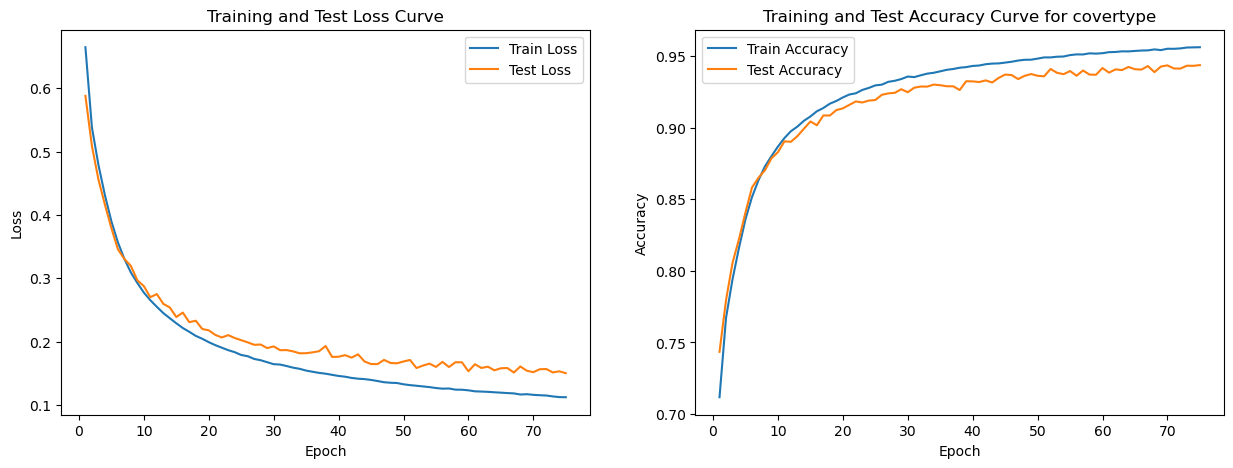

In [15]:
model = Classifier(n_features=54, pre_norm_on=True, rff_on=True, targets_classes=[7], embed_size=40).to(device_in_use) # Instantiate the model
loss_functions = UncertaintyLoss(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.

epochs = 75 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
train_accuracies_2 = []
train_recalls = [] 
train_f1_scores = [] 
test_losses = []
test_accuracies_1 = []
test_accuracies_2 = []
test_recalls = []  
test_f1_scores = [] 
all_attention_scores = []

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  # test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, covertype Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, covertype Accuracy {format_metric(test_accuracy_1)}, covertype F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

  # Save the model after pre-training
  torch.save(model.state_dict(), 'model_trained.pth')

  # total_attention = model.decoder.avg_attention
  # all_attention_scores.append(total_attention.tolist()) #UPDATED
  # model.decoder.avg_attention = None


# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve for covertype')
plt.legend()


# plt.subplot(1, 3, 3)
# plt.plot(range(1, epochs+1), train_accuracies_2, label='Train Accuracy')
# plt.plot(range(1, epochs+1), test_accuracies_2, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Test Accuracy Curve for Traffic Type')
# plt.legend()
# plt.tight_layout()
# plt.tight_layout()
# plt.show()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for covertype")
print(conf_matrix_1)

# # Display confusion matrix for the second task (Application Type) on test data
# conf_matrix_2 = confusion_matrix(all_targets_2, all_predictions_2)
# print("Confusion Matrix for Application Type")
# print(conf_matrix_2)

# print(f"Best accuracy: {max(test_accuracies)}")

# # Plot attention scores for each feature over epochs

# # all_attention_scores = all_attention_scores.cpu().numpy() #CUDA tensor needs to be converted to cpu tensor
# all_attention_scores = torch.tensor(all_attention_scores)
# plt.figure(figsize=(10, 6))

# features = df.drop("class1", axis=1).columns.tolist()

# for feature_idx in range(all_attention_scores.shape[1]):
#     plt.plot(all_attention_scores[:, feature_idx], label=features[feature_idx])

# plt.xlabel('Epochs')
# plt.ylabel('Attention Scores')
# plt.title('Attention Scores for Each Feature over Epochs')
# plt.legend(loc = 'lower left')
# plt.show()

# last_epoch_attention_scores = all_attention_scores[-1]
# top_scores, top_indices = torch.topk(last_epoch_attention_scores, k=10)

# # Display the top 10 attention scores and the corresponding feature
# for i in range(10):
#     print(f"{i+1}. {features[int(top_indices[i])]}: {top_scores[i]}")

In [11]:
model = Classifier(n_features=54, pre_norm_on=True, rff_on=True, targets_classes=[7], embed_size=60).to(device_in_use) # Instantiate the model #added a layer to each head
loss_functions = UncertaintyLoss(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.

epochs = 100 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
train_accuracies_2 = []
train_recalls = [] 
train_f1_scores = [] 
test_losses = []
test_accuracies_1 = []
test_accuracies_2 = []
test_recalls = []  
test_f1_scores = [] 
all_attention_scores = []

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  # test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, covertype Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, covertype Accuracy {format_metric(test_accuracy_1)}, covertype F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

  # Save the model after pre-training
  torch.save(model.state_dict(), 'model_trained.pth')

  # total_attention = model.decoder.avg_attention
  # all_attention_scores.append(total_attention.tolist()) #UPDATED
  # model.decoder.avg_attention = None


# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve for covertype')
plt.legend()


# plt.subplot(1, 3, 3)
# plt.plot(range(1, epochs+1), train_accuracies_2, label='Train Accuracy')
# plt.plot(range(1, epochs+1), test_accuracies_2, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Test Accuracy Curve for Traffic Type')
# plt.legend()
# plt.tight_layout()
# plt.tight_layout()
# plt.show()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for covertype")
print(conf_matrix_1)

# # Display confusion matrix for the second task (Application Type) on test data
# conf_matrix_2 = confusion_matrix(all_targets_2, all_predictions_2)
# print("Confusion Matrix for Application Type")
# print(conf_matrix_2)

# print(f"Best accuracy: {max(test_accuracies)}")

# # Plot attention scores for each feature over epochs

# # all_attention_scores = all_attention_scores.cpu().numpy() #CUDA tensor needs to be converted to cpu tensor
# all_attention_scores = torch.tensor(all_attention_scores)
# plt.figure(figsize=(10, 6))

# features = df.drop("class1", axis=1).columns.tolist()

# for feature_idx in range(all_attention_scores.shape[1]):
#     plt.plot(all_attention_scores[:, feature_idx], label=features[feature_idx])

# plt.xlabel('Epochs')
# plt.ylabel('Attention Scores')
# plt.title('Attention Scores for Each Feature over Epochs')
# plt.legend(loc = 'lower left')
# plt.show()

# last_epoch_attention_scores = all_attention_scores[-1]
# top_scores, top_indices = torch.topk(last_epoch_attention_scores, k=10)

# # Display the top 10 attention scores and the corresponding feature
# for i in range(10):
#     print(f"{i+1}. {features[int(top_indices[i])]}: {top_scores[i]}")

Epoch [ 1/100]       | Train: Loss 0.64, covertype Accuracy 0.72                         | Test: Loss 0.56, covertype Accuracy 0.75, covertype F1 0.74
Epoch [ 2/100]       | Train: Loss 0.49, covertype Accuracy 0.79                         | Test: Loss 0.44, covertype Accuracy 0.81, covertype F1 0.81
Epoch [ 3/100]       | Train: Loss 0.40, covertype Accuracy 0.83                         | Test: Loss 0.35, covertype Accuracy 0.86, covertype F1 0.85
Epoch [ 4/100]       | Train: Loss 0.32, covertype Accuracy 0.87                         | Test: Loss 0.30, covertype Accuracy 0.88, covertype F1 0.88
Epoch [ 5/100]       | Train: Loss 0.27, covertype Accuracy 0.89                         | Test: Loss 0.25, covertype Accuracy 0.90, covertype F1 0.90
Epoch [ 6/100]       | Train: Loss 0.23, covertype Accuracy 0.91                         | Test: Loss 0.22, covertype Accuracy 0.91, covertype F1 0.91
Epoch [ 7/100]       | Train: Loss 0.21, covertype Accuracy 0.92                         | Tes

KeyboardInterrupt: 

Epoch [ 1/10]        | Train: Loss 0.98, covertype Accuracy 0.59                         | Test: Loss 0.77, covertype Accuracy 0.66, covertype F1 0.64
Epoch [ 2/10]        | Train: Loss 0.75, covertype Accuracy 0.66                         | Test: Loss 0.74, covertype Accuracy 0.67, covertype F1 0.65
Epoch [ 3/10]        | Train: Loss 0.73, covertype Accuracy 0.67                         | Test: Loss 0.73, covertype Accuracy 0.67, covertype F1 0.65
Epoch [ 4/10]        | Train: Loss 0.72, covertype Accuracy 0.67                         | Test: Loss 0.71, covertype Accuracy 0.68, covertype F1 0.66
Epoch [ 5/10]        | Train: Loss 0.71, covertype Accuracy 0.68                         | Test: Loss 0.71, covertype Accuracy 0.68, covertype F1 0.66
Epoch [ 6/10]        | Train: Loss 0.70, covertype Accuracy 0.68                         | Test: Loss 0.70, covertype Accuracy 0.69, covertype F1 0.67
Epoch [ 7/10]        | Train: Loss 0.70, covertype Accuracy 0.69                         | Tes

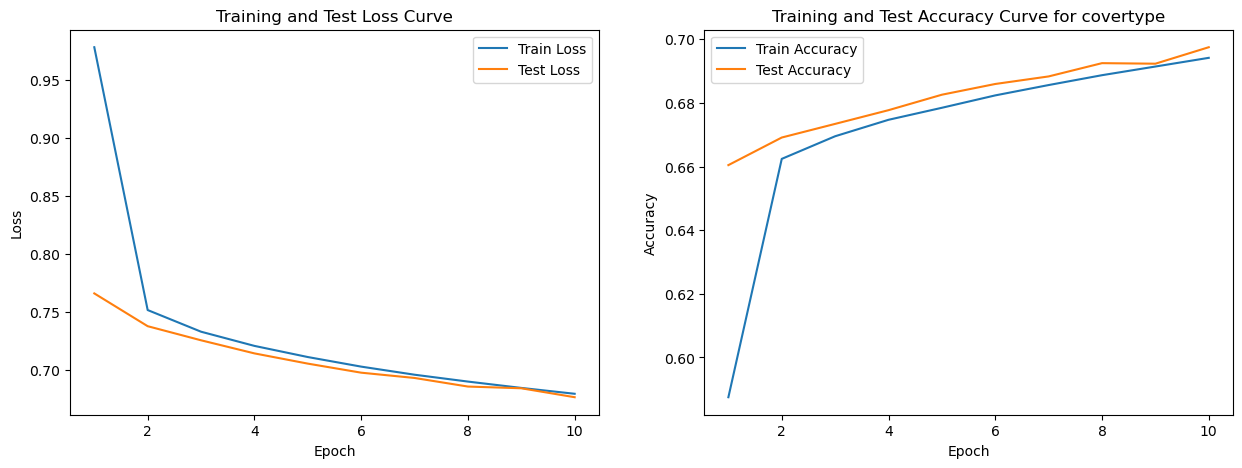

In [11]:
model = Classifier(n_features=54, pre_norm_on=True, rff_on=True, targets_classes=[7]).to(device_in_use) # Instantiate the model
loss_functions = UncertaintyLoss(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.0001) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.

epochs = 10 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
train_accuracies_2 = []
train_recalls = [] 
train_f1_scores = [] 
test_losses = []
test_accuracies_1 = []
test_accuracies_2 = []
test_recalls = []  
test_f1_scores = [] 
all_attention_scores = []

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  # test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, covertype Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, covertype Accuracy {format_metric(test_accuracy_1)}, covertype F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

  # Save the model after pre-training
  torch.save(model.state_dict(), 'model2_trained.pth')

  # total_attention = model.decoder.avg_attention
  # all_attention_scores.append(total_attention.tolist()) #UPDATED
  # model.decoder.avg_attention = None


# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve for covertype')
plt.legend()


# plt.subplot(1, 3, 3)
# plt.plot(range(1, epochs+1), train_accuracies_2, label='Train Accuracy')
# plt.plot(range(1, epochs+1), test_accuracies_2, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Test Accuracy Curve for Traffic Type')
# plt.legend()
# plt.tight_layout()
# plt.tight_layout()
# plt.show()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for covertype")
print(conf_matrix_1)

# # Display confusion matrix for the second task (Application Type) on test data
# conf_matrix_2 = confusion_matrix(all_targets_2, all_predictions_2)
# print("Confusion Matrix for Application Type")
# print(conf_matrix_2)

# print(f"Best accuracy: {max(test_accuracies)}")

# # Plot attention scores for each feature over epochs

# # all_attention_scores = all_attention_scores.cpu().numpy() #CUDA tensor needs to be converted to cpu tensor
# all_attention_scores = torch.tensor(all_attention_scores)
# plt.figure(figsize=(10, 6))

# features = df.drop("class1", axis=1).columns.tolist()

# for feature_idx in range(all_attention_scores.shape[1]):
#     plt.plot(all_attention_scores[:, feature_idx], label=features[feature_idx])

# plt.xlabel('Epochs')
# plt.ylabel('Attention Scores')
# plt.title('Attention Scores for Each Feature over Epochs')
# plt.legend(loc = 'lower left')
# plt.show()

# last_epoch_attention_scores = all_attention_scores[-1]
# top_scores, top_indices = torch.topk(last_epoch_attention_scores, k=10)

# # Display the top 10 attention scores and the corresponding feature
# for i in range(10):
#     print(f"{i+1}. {features[int(top_indices[i])]}: {top_scores[i]}")

Epoch [ 1/10]        | Train: Loss 0.86, covertype Accuracy 0.64                         | Test: Loss 0.69, covertype Accuracy 0.71, covertype F1 0.69
Epoch [ 2/10]        | Train: Loss 0.65, covertype Accuracy 0.72                         | Test: Loss 0.62, covertype Accuracy 0.73, covertype F1 0.73
Epoch [ 3/10]        | Train: Loss 0.61, covertype Accuracy 0.74                         | Test: Loss 0.62, covertype Accuracy 0.74, covertype F1 0.73
Epoch [ 4/10]        | Train: Loss 0.59, covertype Accuracy 0.75                         | Test: Loss 0.58, covertype Accuracy 0.75, covertype F1 0.74
Epoch [ 5/10]        | Train: Loss 0.58, covertype Accuracy 0.75                         | Test: Loss 0.57, covertype Accuracy 0.75, covertype F1 0.75
Epoch [ 6/10]        | Train: Loss 0.57, covertype Accuracy 0.76                         | Test: Loss 0.56, covertype Accuracy 0.76, covertype F1 0.75
Epoch [ 7/10]        | Train: Loss 0.56, covertype Accuracy 0.76                         | Tes

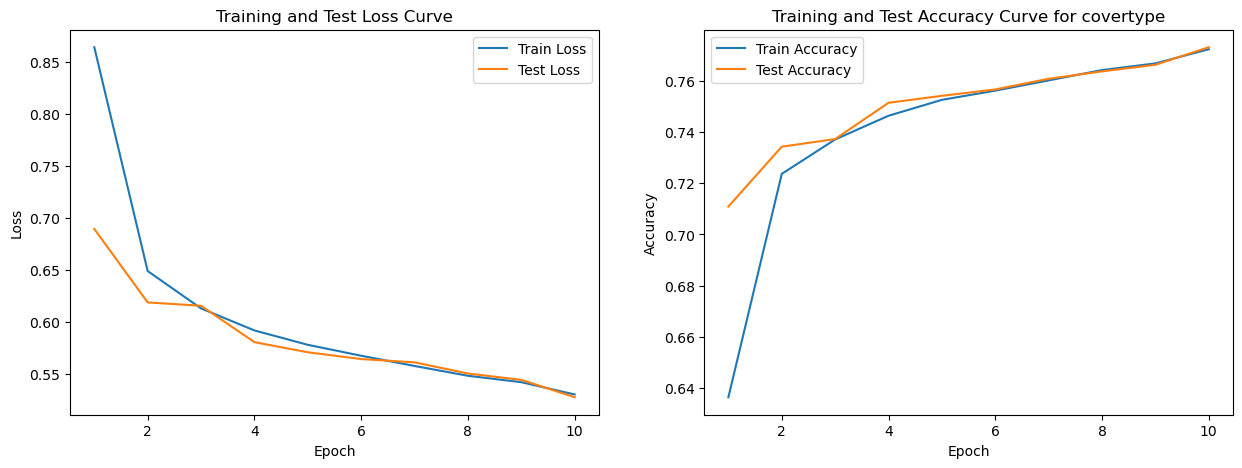

In [12]:
model = Classifier(n_features=54, pre_norm_on=True, rff_on=True, targets_classes=[7]).to(device_in_use) # Instantiate the model
loss_functions = UncertaintyLoss(1)
optimizer = torch.optim.Adam(params=model.parameters(), lr = 0.01) # Maybe try messing around with optimizers. try other torch optimizers with different configurations.

epochs = 10 #Set the number of epochs

train_losses = []
train_accuracies_1 = [] 
train_accuracies_2 = []
train_recalls = [] 
train_f1_scores = [] 
test_losses = []
test_accuracies_1 = []
test_accuracies_2 = []
test_recalls = []  
test_f1_scores = [] 
all_attention_scores = []

for t in range(epochs):
  train_loss, train_accuracy_1 = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, test_accuracy_1, all_predictions_1, all_targets_1, f1_1 = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  train_losses.append(train_loss)
  train_accuracies_1.append(train_accuracy_1)
  # train_accuracies_2.append(train_accuracy_2)
  # train_recalls.append(train_recall) 
  # train_f1_scores.append(train_f1)
  test_losses.append(test_loss)
  test_accuracies_1.append(test_accuracy_1)
  # test_accuracies_2.append(test_accuracy_2)
  # test_recalls.append(test_recall)
  # test_f1_scores.append(test_f1)
  # Formatting for easier reading
  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, covertype Accuracy {format_metric(train_accuracy_1)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, covertype Accuracy {format_metric(test_accuracy_1)}, covertype F1 {format_metric(f1_1)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")

  # Save the model after pre-training
  torch.save(model.state_dict(), 'model2_trained.pth')

  # total_attention = model.decoder.avg_attention
  # all_attention_scores.append(total_attention.tolist()) #UPDATED
  # model.decoder.avg_attention = None


# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs+1), train_accuracies_1, label='Train Accuracy')
plt.plot(range(1, epochs+1), test_accuracies_1, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy Curve for covertype')
plt.legend()


# plt.subplot(1, 3, 3)
# plt.plot(range(1, epochs+1), train_accuracies_2, label='Train Accuracy')
# plt.plot(range(1, epochs+1), test_accuracies_2, label='Test Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Training and Test Accuracy Curve for Traffic Type')
# plt.legend()
# plt.tight_layout()
# plt.tight_layout()
# plt.show()

# Display confusion matrix for the first task (Traffic Type) on test data
conf_matrix_1 = confusion_matrix(all_targets_1, all_predictions_1)
print("Confusion Matrix for covertype")
print(conf_matrix_1)

# # Display confusion matrix for the second task (Application Type) on test data
# conf_matrix_2 = confusion_matrix(all_targets_2, all_predictions_2)
# print("Confusion Matrix for Application Type")
# print(conf_matrix_2)

# print(f"Best accuracy: {max(test_accuracies)}")

# # Plot attention scores for each feature over epochs

# # all_attention_scores = all_attention_scores.cpu().numpy() #CUDA tensor needs to be converted to cpu tensor
# all_attention_scores = torch.tensor(all_attention_scores)
# plt.figure(figsize=(10, 6))

# features = df.drop("class1", axis=1).columns.tolist()

# for feature_idx in range(all_attention_scores.shape[1]):
#     plt.plot(all_attention_scores[:, feature_idx], label=features[feature_idx])

# plt.xlabel('Epochs')
# plt.ylabel('Attention Scores')
# plt.title('Attention Scores for Each Feature over Epochs')
# plt.legend(loc = 'lower left')
# plt.show()

# last_epoch_attention_scores = all_attention_scores[-1]
# top_scores, top_indices = torch.topk(last_epoch_attention_scores, k=10)

# # Display the top 10 attention scores and the corresponding feature
# for i in range(10):
#     print(f"{i+1}. {features[int(top_indices[i])]}: {top_scores[i]}")